In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 123
learning_rate = 0.001
num_epochs = 25
batch_size = 256

# Architecture
num_features = 1024
num_classes = 10


##########################
### MNIST DATASET
##########################

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

train_dataset = datasets.CIFAR10(root='./data/', 
                               train=True, 
                               transform=train_transform,
                               download=True)

test_dataset = datasets.CIFAR10(root='./data/', 
                              train=False, 
                              transform=test_transform)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)


# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape) #NCHW
    print('Image label dimensions:', labels.shape)
    break
# Checking the dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape) #NCHW
    print('Image label dimensions:', labels.shape)
    break

100%|██████████| 170498071/170498071 [00:01<00:00, 85522917.37it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Image batch dimensions: torch.Size([256, 1, 32, 32])
Image label dimensions: torch.Size([256])
Image batch dimensions: torch.Size([256, 1, 32, 32])
Image label dimensions: torch.Size([256])


In [3]:
##########################
### MODEL
##########################

class SoftmaxRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        
    def forward(self, x):
        logits = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

model = SoftmaxRegression(num_features=num_features,
                          num_classes=num_classes)
# Load the saved model
model.load_state_dict(torch.load('./cifar10_softwmaxRegression.pth'))
model.to(device)
model.eval()

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [4]:
model.get_parameter

<bound method Module.get_parameter of SoftmaxRegression(
  (linear): Linear(in_features=1024, out_features=10, bias=True)
)>

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
predicted_labels = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.view(-1, num_features).to(device)
        _, probas = model(images)
        _, predicted_label = torch.max(probas, 1)
        predicted_labels.extend(predicted_label.cpu().numpy())

        if len(predicted_labels) >= 6:
            break

# Print the predicted labels
print("Predicted Labels:")
print("-----------------")
for i, label in enumerate(predicted_labels[:6]):
    print(f"Image {i + 1}: Predicted Label - {class_names[label]}")

Predicted Labels:
-----------------
Image 1: Predicted Label - frog
Image 2: Predicted Label - truck
Image 3: Predicted Label - ship
Image 4: Predicted Label - ship
Image 5: Predicted Label - cat
Image 6: Predicted Label - frog


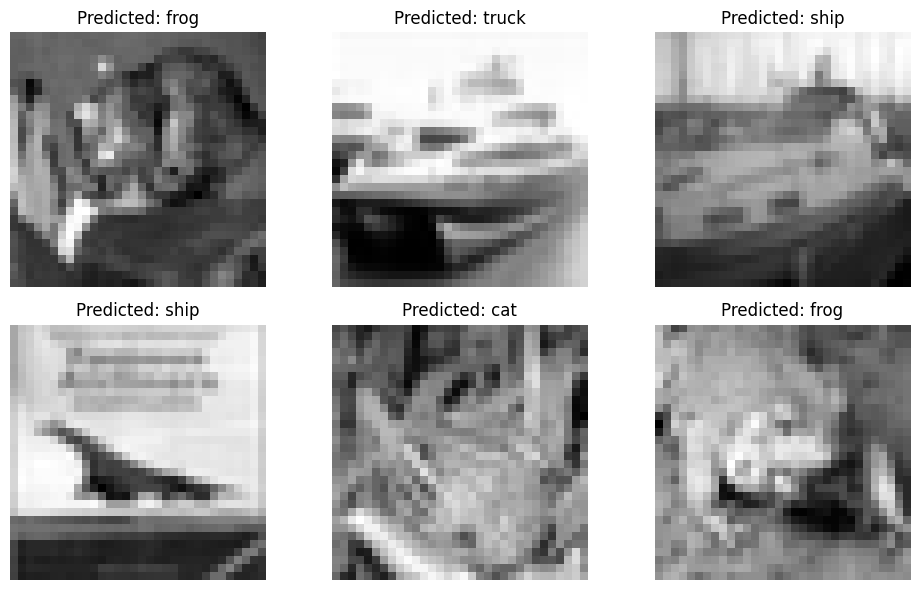

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# Display the first 6 images with predicted labels
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
count = 0
with torch.no_grad():
    for images, _ in test_loader:
        images = images.view(-1, num_features).to(device)
        _, probas = model(images)
        _, predicted_labels = torch.max(probas, 1)
        
        for i in range(images.size(0)):
            predicted_label = predicted_labels[i].item()
            
            image = images[i].view(32, 32).cpu().numpy()
            axes[count // 3, count % 3].imshow(image, cmap='gray')
            axes[count // 3, count % 3].set_title(f"Predicted: {class_names[predicted_label]}")
            axes[count // 3, count % 3].axis('off')
            
            count += 1
            if count >= 6:
                break
        
        if count >= 6:
            break

plt.tight_layout()
plt.show()